In [1]:
import numpy as np 
import os
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import math
from matplotlib import pyplot as plt

import sys
sys.path.append('../utils')

from text.utils import save_text_state, load_text_state, build_text_state, load_books
from model.utils import get_device, load_model_state, save_model_state, build_model_state

from text_model import TextModel, get_loss_function

### Verify if CUDA is available

In [2]:
device = get_device()
print(device)

cuda


### Loading word vectors and training/validation dataset

In [3]:
LOAD_CHECKPOINTS = True

CHECKPOINT_BASE = 'checkpoints'
DATASET_FILENAME = '../datasets/books.pk'
AUTHOR = 'Friedrich Nietzsche'

VAL_PARTITION = 0.3 
SENTENCE_LENGTH = 27
BATCH_SIZE = 8

In [4]:
# Try loading dataset, if it doesn't exists then creates it
try:
    if not LOAD_CHECKPOINTS:
        print('New training required')
        raise Error('New training required')
        
    vocab, train_dataset, test_dataset = load_text_state(os.path.join(CHECKPOINT_BASE, AUTHOR + '_text.pk'))    
    print('Checkpoint loaded')
except:
    books = load_books(DATASET_FILENAME, author=AUTHOR)
    vocab, train_dataset, test_dataset = build_text_state(books, SENTENCE_LENGTH, VAL_PARTITION, vocab_name=AUTHOR)  
    print('No checkpoint found. New partition.')
    print('Included books:')
    for book in books:
        print('\t', book)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

No checkpoint found. New partition.
Included books:
	 Name: The antichrist   Author: Friedrich Nietzsche
	 Name: Thus spake Zarathustra   Author: Friedrich Nietzsche


In [5]:
save_text_state(os.path.join(CHECKPOINT_BASE, AUTHOR + '_text.pk'), vocab, train_dataset, test_dataset) 

### Loading components

In [6]:
VOCAB_SIZE = len(vocab)

LEARNING_RATE = 1e-4
BETA_1 = 0.1
BETA_2 = 0.999
EPOCHS = 50
NUM_HEADS = 8
ENCODER_LAYERS = 1
DECODER_LAYERS = 1
EMBEDDING_SIZE = 512
FF_DIM = 1024
DROPOUT=0.1
STEP_LR_DECAY = 15
LR_FACTOR_DECAY = 0.5

In [7]:
model = TextModel(
    vocab_size=VOCAB_SIZE,
    embedding_size=EMBEDDING_SIZE, 
    num_heads=NUM_HEADS, 
    encoder_layers=ENCODER_LAYERS, 
    decoder_layers=DECODER_LAYERS, 
    dim_feedforward=FF_DIM,
    dropout=DROPOUT
)

optimizer = torch.optim.Adam(
    list(model.parameters()), 
    lr=LEARNING_RATE,
    betas=(BETA_1, BETA_2)
)

loss_fn = get_loss_function()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP_LR_DECAY, gamma=LR_FACTOR_DECAY)

In [8]:
try:
    if not LOAD_CHECKPOINTS:
        print('New training required')
        raise Error('New training required')
        
    model, optimizer, last_epoch, train_loss_history, val_loss_history, best_val_loss = load_model_state(
        os.path.join(CHECKPOINT_BASE, AUTHOR + '_best.pt'), 
        model, 
        optimizer
    )
    
    for state in optimizer.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.to(device)

    print('Checkpoint loaded')
    
except:
    last_epoch, train_loss_history, val_loss_history, best_val_loss = build_model_state()
    print('No checkpoints found. New training.')
    pass

model = model.to(device)


No checkpoints found. New training.


### Training and validation

In [9]:
def train_step(transformer, loss_fn, optimizer, batch):
    transformer.train()

    transformer.zero_grad()
    optimizer.zero_grad()

    decodings = transformer(batch[:,1:], batch[:,:-1])
    
    loss = loss_fn(batch[:,1:], decodings)
    loss.backward()
    optimizer.step()
    return loss.item()    

In [10]:
def val_step(transformer, loss_fn, batch):
    transformer.eval()
    
    with torch.no_grad():
        decodings = transformer(batch[:,1:], batch[:,:-1])
        loss = loss_fn(batch[:,1:], decodings)

        return loss.item(), decodings

In [11]:
# Define steps where examples will be sampled 
test_examples = iter(test_dataloader)

# For EPOCHS
for epoch in range(last_epoch + 1, EPOCHS + last_epoch):
    
    print('*************************** EPOCH {} ***************************'.format(epoch))

    # Restart train dataset
    examples = iter(train_dataloader)

    # Progress bar for training dataset
    progress_bar = tqdm(range(len(train_dataloader)))
    train_loss = 0

    # For all data in training dataset
    # Training
    for batch_idx in progress_bar:

        # Add train loss to progress bar
        progress_bar.set_postfix({
            'tr_loss': train_loss / (batch_idx + 1), 
            'lr': scheduler.get_lr()[0]
        })

        # Train step
        example = next(examples).to(device)
        train_loss += train_step(model, loss_fn, optimizer, example)


        if batch_idx == 0:
            try:
                example = next(test_examples).to(device)
            except:
                test_examples = iter(test_dataloader)
                example = next(test_examples).to(device)

            with torch.no_grad():
                _, decodings = val_step(model, loss_fn, example)
                decodings = torch.argmax(decodings[0], dim=-1).cpu().numpy()

            print('\nReal: {}'.format(vocab.to_words(example[0][1:].cpu().numpy())))
            print('Decoded: {}'.format(vocab.to_words(decodings)))

    # Validation
    val_examples = iter(test_dataloader)
    progress_bar = tqdm(range(len(test_dataloader)))
    val_loss = 0

    for batch_idx in progress_bar:
        progress_bar.set_postfix({
            'val_loss': val_loss / (batch_idx + 1)
        })
        
        example = next(val_examples).to(device)
        
        with torch.no_grad():
            val_loss += val_step(model, loss_fn, example)[0]
    
    # Save losses in history
    train_loss_history.append(train_loss / len(train_dataloader))
    val_loss_history.append(val_loss / len(test_dataloader))
    
    # If this model is best than other
    if best_val_loss is None or val_loss < best_val_loss:
        best_val_loss = val_loss
        
        save_model_state(
            os.path.join(CHECKPOINT_BASE, AUTHOR + '_best.pt'), 
            model, 
            optimizer, 
            epoch, 
            train_loss_history, 
            val_loss_history, 
            best_val_loss
        )
        
    # Save last model
    save_model_state(
        os.path.join(CHECKPOINT_BASE, AUTHOR + '_last.pt'), 
        model, 
        optimizer, 
        epoch, 
        train_loss_history, 
        val_loss_history, 
        best_val_loss
    )    
    
    scheduler.step()    

*************************** EPOCH 1 ***************************



Real: ['to', 'be', 'true', 'that', 'can', 'few', 'be', '!', 'and', 'he', 'who', 'can', ',', 'will', 'not', '!', 'least', 'of', 'all', ',', 'however', ',', 'can', 'the', 'good', 'be', 'true', '<eos>']
Decoded: ['<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']




*************************** EPOCH 2 ***************************



Real: ['<unk>', 'did', 'he', 'now', 'see', 'himself', 'as', 'the', 'doer', 'of', 'one', 'deed', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: [',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 3 ***************************



Real: ["'", 'twixt', 'rosy', 'dawn', 'and', 'rosy', 'dawn', 'there', 'came', 'unto', 'me', 'a', 'new', 'truth', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['it', 'i', 'in', '<pad>', 'and', ',', '<pad>', ',', '<pad>', '<pad>', '<pad>', 'to', 'it', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 4 ***************************



Real: ['the', 'priest', 'himself', 'is', 'seen', 'as', 'he', 'actually', 'is', 'as', 'the', 'most', 'dangerous', 'form', 'of', 'parasite', ',', 'as', 'the', 'venomous', 'spider', 'of', 'creation', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['the', 'me', '<pad>', 'is', 'me', 'as', 'he', 'one', 'is', 'as', 'the', 'me', 'me', 'me', 'of', 'me', ',', 'as', 'the', 'me', 'me', 'of', 'life', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 5 ***************************



Real: ['and', 'when', 'they', 'are', 'even', 'the', 'last', 'men', ',', 'and', 'more', 'beast', 'than', 'man', ',', 'then', 'riseth', 'and', 'riseth', 'the', 'populace', 'in', 'honour', ',', 'and', 'at', 'last', '<eos>']
Decoded: ['and', 'when', 'they', 'are', 'even', 'the', 'good', 'men', ',', 'and', 'more', 'him', 'than', 'man', ',', 'then', 'men', 'and', 'even', 'the', 'good', 'in', 'good', ',', 'and', 'at', 'not', '<eos>']




*************************** EPOCH 6 ***************************



Real: ['my', 'voice', '<unk>', 'even', 'the', 'deaf', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['my', 'voice', 'men', 'even', 'the', 'soul', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 7 ***************************



Real: ['o', 'happiness', '!', 'o', 'happiness', '!', 'wilt', 'thou', 'perhaps', 'sing', ',', 'o', 'my', 'soul', '?', 'thou', '<unk>', 'in', 'the', 'grass', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['o', 'happiness', '!', 'o', 'happiness', '!', 'wilt', 'thou', 'perhaps', 'alone', ',', 'o', 'my', 'soul', '?', 'thou', 'something', 'in', 'the', 'hour', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 8 ***************************



Real: ['for', 'such', '<unk>', 'neither', 'thy', 'mouth', 'nor', 'thine', 'eye', 'have', 'been', 'given', 'thee', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['for', 'such', 'something', 'made', 'thy', 'mouth', 'nor', 'thine', 'eye', 'have', 'been', 'given', 'thee', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 9 ***************************



Real: ['at', 'last', 'he', 'spake', 'thus', 'and', 'his', 'voice', 'had', 'changed', ':', 'the', 'man', 'of', 'knowledge', 'must', 'be', 'able', 'not', 'only', 'to', 'love', 'his', 'enemies', ',', 'but', 'also', '<eos>']
Decoded: ['at', 'last', 'he', 'spake', 'thus', 'and', 'his', 'voice', 'had', 'formerly', ':', 'the', 'man', 'of', 'knowledge', 'must', 'be', 'able', 'not', 'only', 'to', 'love', 'his', 'enemies', ',', 'but', 'also', '<eos>']




*************************** EPOCH 10 ***************************



Real: ['and', 'the', 'bowels', 'of', 'existence', 'do', 'not', 'speak', 'unto', 'man', ',', 'except', 'as', 'man', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['and', 'the', 'beauty', 'of', 'existence', 'do', 'not', 'speak', 'unto', 'man', ',', 'except', 'as', 'man', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 11 ***************************



Real: ['thus', 'doth', 'it', 'cause', 'thirst', 'in', 'thee', ',', 'the', 'creating', 'one', '!', 'thirst', 'in', 'the', 'creating', 'one', ',', 'arrow', 'and', 'longing', 'for', 'the', 'superman', ':', 'tell', 'me', '<eos>']
Decoded: ['thus', 'doth', 'it', 'cause', 'thirst', 'in', 'thee', ',', 'the', 'creating', 'one', '!', 'thirst', 'in', 'the', 'creating', 'one', ',', 'left', 'and', 'longing', 'for', 'the', 'superman', ':', 'tell', 'me', '<eos>']




*************************** EPOCH 12 ***************************



Real: ['ere', 'zarathustra', 'had', 'been', 'an', 'hour', 'on', 'his', 'way', 'in', 'the', 'mountains', 'and', 'forests', ',', 'he', 'saw', 'all', 'at', 'once', 'a', 'strange', 'procession', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['lost', 'zarathustra', 'had', 'been', 'an', 'hour', 'on', 'his', 'way', 'in', 'the', 'mountains', 'and', 'forests', ',', 'he', 'saw', 'all', 'at', 'once', 'a', 'strange', 'forgiving', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 13 ***************************



Real: ['is', 'it', 'understood', 'at', 'last', ',', 'will', 'it', 'ever', 'be', 'understood', ',', 'what', 'the', 'renaissance', 'was', '?', 'the', 'transvaluation', 'of', 'christian', 'values', ',', 'an', 'attempt', 'with', 'all', '<eos>']
Decoded: ['is', 'it', 'understood', 'at', 'last', ',', 'will', 'it', 'ever', 'be', 'understood', ',', 'what', 'the', 'renaissance', 'was', '?', 'the', 'burden', 'of', 'christian', 'values', ',', 'an', 'attempt', 'with', 'all', '<eos>']




*************************** EPOCH 14 ***************************



Real: ['this', 'therefore', 'would', 'be', '<unk>', 'itself', 'as', 'a', 'criterion', 'of', 'truth', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['this', 'therefore', 'would', 'be', 'prompts', 'itself', 'as', 'a', 'sake', 'of', 'truth', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 15 ***************************



Real: ['zarathustra', 'however', 'got', 'up', ',', 'and', 'prepared', 'to', 'go', 'on', ':', 'for', 'he', 'felt', '<unk>', 'to', 'the', 'very', 'bowels', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['zarathustra', 'however', 'got', 'up', ',', 'and', 'replace', 'to', 'go', 'on', ':', 'for', 'he', 'felt', 'prompts', 'to', 'the', 'very', 'secrecy', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 16 ***************************



Real: ['but', 'even', 'your', 'best', 'love', 'is', 'only', 'an', 'enraptured', 'simile', 'and', 'a', '<unk>', '<unk>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['but', 'even', 'your', 'best', 'love', 'is', 'only', 'an', 'burden', '5', 'and', 'a', 'failure', 'prompts', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 17 ***************************



Real: ['art', 'thou', 'not', 'the', 'light', 'of', 'my', 'fire', '?', 'hast', 'thou', 'not', 'the', '<unk>', 'soul', 'of', 'mine', '<unk>', '?', 'together', 'did', 'we', 'learn', 'everything', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['art', 'thou', 'not', 'the', 'light', 'of', 'my', 'fire', '?', 'hast', 'thou', 'not', 'the', 'failure', 'soul', 'of', 'mine', 'failure', '?', 'together', 'did', 'we', 'learn', 'everything', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 18 ***************************



Real: ['the', 'second', '<unk>', ':', 'to', 'this', 'belong', 'the', '<unk>', 'of', 'the', 'law', ',', 'the', '<unk>', 'of', 'order', 'and', 'security', ',', 'the', 'more', 'noble', '<unk>', ',', 'above', 'all', '<eos>']
Decoded: ['the', 'second', 'prompts', ':', 'to', 'this', 'belong', 'the', 'failure', 'of', 'the', 'law', ',', 'the', 'failure', 'of', 'order', 'and', 'security', ',', 'the', 'more', 'noble', 'leaves', ',', 'above', 'all', '<eos>']




*************************** EPOCH 19 ***************************



Real: ['that', 'doth', 'not', 'concern', 'me', ',', 'said', 'the', 'old', 'man', '<unk>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['that', 'doth', 'not', 'concern', 'me', ',', 'said', 'the', 'old', 'man', 'prompts', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 20 ***************************



Real: ['it', 'must', 'spring', 'out', 'of', 'our', 'personal', 'need', 'and', '<unk>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['it', 'must', 'spring', 'out', 'of', 'our', 'personal', 'need', 'and', 'failure', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 21 ***************************



Real: ['and', 'much', 'poison', 'at', 'last', 'for', 'a', 'pleasant', 'death', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['and', 'much', 'poison', 'at', 'last', 'for', 'a', 'pleasant', 'death', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 22 ***************************



Real: ['even', 'whole', 'races', ',', '<unk>', 'and', '<unk>', 'may', 'occasionally', 'represent', 'such', '<unk>', 'accidents', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['even', 'whole', 'sadly', ',', 'prompts', 'and', 'failure', 'may', 'ventured', 'represent', 'such', 'failure', 'accidents', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 23 ***************************



Real: ['not', ',', 'of', 'course', ',', 'to', 'a', 'priest', ':', 'for', 'his', 'instincts', '<unk>', 'him', 'to', 'the', 'lie', 'that', 'sickness', 'is', 'not', 'sickness', 'and', 'lunatic', '<unk>', 'not', 'lunatic', '<eos>']
Decoded: ['not', ',', 'of', 'course', ',', 'to', 'a', 'priest', ':', 'for', 'his', 'instincts', 'asserts', 'him', 'to', 'the', 'lie', 'that', 'sickness', 'is', 'not', 'sickness', 'and', 'rome', 'asserts', 'not', 'rome', '<eos>']




*************************** EPOCH 24 ***************************



Real: ['i', 'bade', 'them', 'laugh', 'at', 'their', 'great', '<unk>', ',', 'their', 'saints', ',', 'their', 'poets', ',', 'and', 'their', 'saviours', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['i', 'prominent', 'them', 'laugh', 'at', 'their', 'great', 'failure', ',', 'their', 'saints', ',', 'their', 'poets', ',', 'and', 'their', 'saviours', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 25 ***************************



Real: ['and', 'if', 'they', 'have', 'learned', 'of', 'me', 'to', 'laugh', ',', 'still', 'it', 'is', 'not', 'my', 'laughter', 'they', 'have', 'learned', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['and', 'if', 'they', 'have', 'learned', 'of', 'me', 'to', 'laugh', ',', 'still', 'it', 'is', 'not', 'my', 'laughter', 'they', 'have', 'learned', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 26 ***************************



Real: ['<unk>', 'is', 'life', 'by', 'the', 'many', 'too', 'many', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['ruleth', 'is', 'life', 'by', 'the', 'many', 'too', 'many', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 27 ***************************



Real: ['he', 'bit', 'with', 'a', 'strong', 'bite', '!', 'far', 'away', 'did', 'he', 'spit', 'the', 'head', 'of', 'the', 'serpent', ':', 'and', 'sprang', 'up', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['he', 'bit', 'with', 'a', 'strong', 'bite', '!', 'far', 'away', 'did', 'he', 'ventured', 'the', 'head', 'of', 'the', 'serpent', ':', 'and', 'sprang', 'up', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 28 ***************************



Real: ['for', ',', 'dost', 'thou', 'remember', ',', 'o', 'zarathustra', '?', 'when', 'thy', 'bird', 'screamed', '<unk>', ',', 'when', 'thou', '<unk>', 'in', 'the', 'forest', ',', '<unk>', ',', 'ignorant', 'where', 'to', '<eos>']
Decoded: ['for', ',', 'dost', 'thou', 'attempt', ',', 'o', 'zarathustra', '?', 'when', 'thy', 'bird', 'ha', 'asserts', ',', 'when', 'thou', 'risk', 'in', 'the', 'forest', ',', 'afric', ',', 'stupidity', 'where', 'to', '<eos>']




*************************** EPOCH 29 ***************************



Real: ['neither', 'has', 'a', 'pleasant', 'smell', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['neither', 'has', 'a', 'pleasant', 'smell', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 30 ***************************



Real: ['ah', ',', 'whither', 'did', 'my', 'tender', 'longing', 'then', 'flee', '?', 'all', 'loathing', 'did', 'i', 'once', 'vow', 'to', 'renounce', ':', 'then', 'did', 'ye', 'change', 'my', 'nigh', 'ones', 'and', '<eos>']
Decoded: ['ah', ',', 'whither', 'did', 'my', 'tender', 'longing', 'then', 'flee', '?', 'all', 'loathing', 'did', 'i', 'once', 'familiarity', 'to', 'wherefore', ':', 'then', 'did', 'ye', 'change', 'my', 'nigh', 'ones', 'and', '<eos>']




*************************** EPOCH 31 ***************************



Real: ["'", 'tis', 'night', ':', 'now', 'do', 'all', 'gushing', 'fountains', 'speak', 'louder', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ["'", 'tis', 'night', ':', 'now', 'do', 'all', 'abrupt', 'fountains', 'speak', 'ruleth', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 32 ***************************



Real: ['round', ',', 'fair', ',', 'and', '<unk>', 'are', 'they', 'to', 'one', 'another', ',', 'as', '<unk>', 'of', 'sand', 'are', 'round', ',', 'fair', ',', 'and', '<unk>', 'to', '<unk>', 'of', 'sand', '<eos>']
Decoded: ['round', ',', 'reapers', ',', 'and', 'failure', 'are', 'they', 'to', 'one', 'another', ',', 'as', 'risk', 'of', 'pastime', 'are', 'round', ',', 'studied', ',', 'and', 'risk', 'to', 'risk', 'of', 'pastime', '<eos>']




*************************** EPOCH 33 ***************************



Real: ['when', 'zarathustra', 'had', 'spoken', 'thus', 'unto', 'the', 'hunchback', ',', 'and', 'unto', 'those', 'of', 'whom', 'the', 'hunchback', 'was', 'the', 'mouthpiece', 'and', 'advocate', ',', 'then', 'did', 'he', 'turn', 'to', '<eos>']
Decoded: ['when', 'zarathustra', 'had', 'spoken', 'thus', 'unto', 'the', 'belly', ',', 'and', 'unto', 'those', 'of', 'whom', 'the', 'ecclesiastical', 'was', 'the', 'stupendous', 'and', 'penance', ',', 'then', 'did', 'he', 'turn', 'to', '<eos>']




*************************** EPOCH 34 ***************************



Real: ['the', '<unk>', 'of', 'christianity', 'cannot', '<unk>', 'the', 'necessity', 'of', 'making', 'christianity', 'contemptible', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['the', 'failure', 'of', 'christianity', 'cannot', 'failure', 'the', 'necessity', 'of', 'making', 'christianity', 'contemptible', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 35 ***************************



Real: ['so', 'they', 'press', 'thee', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['so', 'they', 'erflowing', 'thee', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 36 ***************************



Real: ['now', 'will', 'a', 'strong', 'wind', 'ever', 'come', '<unk>', 'unto', 'all', 'mortal', 'weariness', ':', 'of', 'this', 'thou', 'art', 'thyself', 'the', 'pledge', 'and', 'the', '<unk>', '!', 'but', 'as', 'thou', '<eos>']
Decoded: ['now', 'will', 'a', 'strong', 'wind', 'ever', 'come', 'prompts', 'unto', 'all', 'mortal', 'weariness', ':', 'of', 'this', 'thou', 'art', 'thyself', 'the', 'ecclesiastical', 'and', 'the', 'risk', '!', 'but', 'as', 'thou', '<eos>']




*************************** EPOCH 37 ***************************



Real: ['not', 'with', 'you', 'may', 'i', 'descend', 'for', 'the', 'last', 'time', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['not', 'with', 'you', 'may', 'i', 'descend', 'for', 'the', 'last', 'time', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 38 ***************************



Real: ['ye', 'are', 'ashamed', 'of', 'your', 'flow', ',', 'and', 'others', 'are', 'ashamed', 'of', 'their', 'ebb', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['ye', 'are', 'ashamed', 'of', 'your', 'flow', ',', 'and', 'others', 'are', 'ashamed', 'of', 'their', 'beareth', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 39 ***************************



Real: ['and', 'if', 'thine', 'eye', 'offend', 'thee', ',', 'pluck', 'it', 'out', ':', 'it', 'is', 'better', 'for', 'thee', 'to', 'enter', 'into', 'the', 'kingdom', 'of', 'god', 'with', 'one', 'eye', ',', '<eos>']
Decoded: ['and', 'if', 'thine', 'eye', 'asserts', 'thee', ',', 'meditateth', 'it', 'out', ':', 'it', 'is', 'better', 'for', 'thee', 'to', 'enter', 'into', 'the', 'kingdom', 'of', 'god', 'with', 'one', 'eye', ',', '<eos>']




*************************** EPOCH 40 ***************************



Real: ['and', 'another', 'of', 'these', 'diseases', 'is', 'called', 'the', 'fire', 'dog', ':', 'concerning', 'him', 'men', 'have', 'greatly', 'deceived', 'themselves', ',', 'and', 'let', 'themselves', 'be', 'deceived', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['and', 'another', 'of', 'these', 'diseases', 'is', 'called', 'the', 'fire', 'dog', ':', 'concerning', 'him', 'men', 'have', 'ventured', 'deceived', 'themselves', ',', 'and', 'let', 'themselves', 'be', 'deceived', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 41 ***************************



Real: ['what', 'is', 'evil', '?', 'whatever', '<unk>', 'from', 'weakness', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['what', 'is', 'evil', '?', 'whatever', 'ruleth', 'from', 'weakness', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 42 ***************************



Real: ["'", 'and', "'", 'truth', "'", 'is', 'at', 'present', 'what', 'the', 'preacher', 'spake', 'who', 'himself', 'sprang', 'from', 'them', ',', 'that', '<unk>', 'saint', 'and', 'advocate', 'of', 'the', 'petty', 'people', '<eos>']
Decoded: ["'", 'and', "'", 'truth', "'", 'is', 'at', 'present', 'what', 'the', 'noblest', 'spake', 'who', 'himself', 'sprang', 'from', 'them', ',', 'that', 'behaved', 'saint', 'and', 'humbled', 'of', 'the', 'petty', 'people', '<eos>']




*************************** EPOCH 43 ***************************



Real: ['so', 'doth', 'it', 'accord', 'with', 'good', 'sleep', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['so', 'doth', 'it', 'accord', 'with', 'good', 'sleep', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 44 ***************************



Real: ['the', 'most', 'common', 'sort', 'of', 'lie', 'is', 'that', 'by', 'which', 'a', 'man', '<unk>', 'himself', ':', 'the', 'deception', 'of', 'others', 'is', 'a', 'relatively', 'rare', 'offence', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['the', 'most', 'common', 'sort', 'of', 'lie', 'is', 'that', 'by', 'which', 'a', 'man', 'asserts', 'himself', ':', 'the', 'perfume', 'of', 'others', 'is', 'a', 'butcher', 'rare', 'meditateth', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 45 ***************************



Real: ['he', 'threw', 'his', '<unk>', 'away', ',', 'and', '<unk>', 'downwards', 'faster', 'than', 'it', ',', 'like', 'an', '<unk>', 'of', 'arms', 'and', 'legs', ',', 'into', 'the', 'depth', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['he', 'threw', 'his', 'failure', 'away', ',', 'and', 'failure', 'downwards', 'replace', 'than', 'it', ',', 'like', 'an', 'risk', 'of', 'pairs', 'and', 'legs', ',', 'into', 'the', 'depth', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 46 ***************************



Real: ['said', 'ye', 'ever', 'yea', 'to', 'one', 'joy', '?', 'o', 'my', 'friends', ',', 'then', 'said', 'ye', 'yea', 'also', 'unto', 'all', 'woe', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['said', 'ye', 'ever', 'yea', 'to', 'one', 'joy', '?', 'o', 'my', 'friends', ',', 'then', 'said', 'ye', 'yea', 'also', 'unto', 'all', 'woe', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 47 ***************************



Real: ['hath', 'not', 'god', 'made', 'foolish', 'the', 'wisdom', 'of', 'this', 'world', '?', 'for', 'after', 'that', 'in', 'the', 'wisdom', 'of', 'god', 'the', 'world', 'by', 'wisdom', 'knew', 'not', 'god', ',', '<eos>']
Decoded: ['hath', 'not', 'god', 'made', 'foolish', 'the', 'wisdom', 'of', 'this', 'world', '?', 'for', 'after', 'that', 'in', 'the', 'wisdom', 'of', 'god', 'the', 'world', 'by', 'wisdom', 'knew', 'not', 'god', ',', '<eos>']




*************************** EPOCH 48 ***************************



Real: ['the', 'physician', 'says', 'incurable', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['the', 'physician', 'says', 'beareth', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']




*************************** EPOCH 49 ***************************



Real: ['to', '<unk>', 'mad', 'that', 'meaneth', 'with', 'him', 'to', 'convince', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']
Decoded: ['to', 'failure', 'loadeth', 'that', 'meaneth', 'with', 'him', 'to', 'convinced', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<eos>']



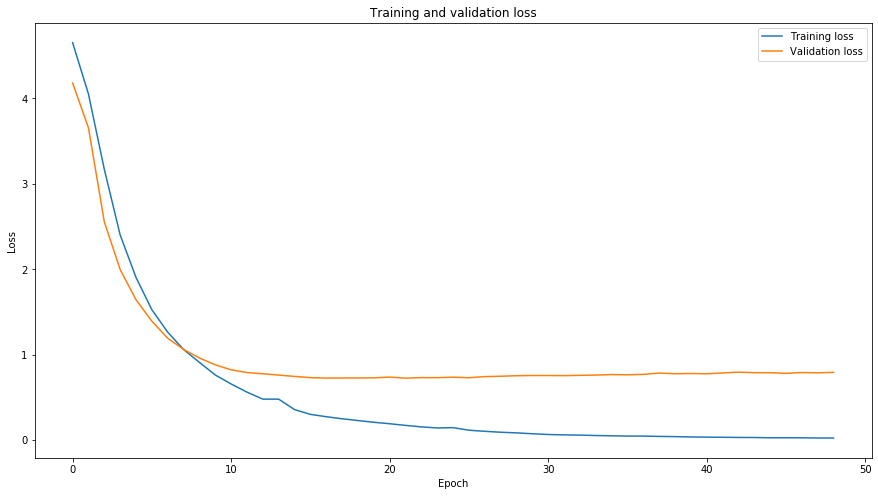

In [12]:
x = [epoch for epoch in range(len(train_loss_history))]
plt.figure(figsize=(15, 8))

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

plt.plot(x, train_loss_history, label='Training loss')
plt.plot(x, val_loss_history, label='Validation loss')

plt.legend()

plt.show()

In [13]:
argmin_val = np.argmin(val_loss_history)
print('Lower validation loss: {} in epoch {}'.format(val_loss_history[argmin_val], argmin_val))

Lower validation loss: 0.7258748434387244 in epoch 21
